                                        INTRODUCTION

WHAT IS A TIME SERIES? 

Time-series is a series of observations that are recorded over a period of time, these observations are dependent of time component which can not be neglected thus we have to analyse this data keeping the time component in mind. 

                                Time Series Forecasting
Time series forecasting is parhaps one of the most common type of machine learning techniques used in real-world scenarios. `time-series forecsting refers to predicting future values from historical data by statical analysis of trends and patterns from certain time-series data.` it falls under unsupervised learning category but called as a self-supervised learning or supervised learning technique. time-series data can be much complex to find patterns out of it, this is because irregular component of time series.
Use-cases and applications:
-Forecast product demand
-Economic growth and population forecasting
-Weather forecasting
-Stock price forecasting
-Sales/Revenue forecasting
-Web-traffic forecasting

                        PROBLEM STATEMENT OF THE NOTEBOOK: 

In this notebook, our problem-statement is to analyse S&P500 stock prices ( we will analyse 10 popular stocks and forecast the future prices) and build forecasting models that beat the market. 

                                IMPORTING LIBRARIES: 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime 
import math 
from scipy import stats 
import matplotlib.dates as mdates 
from plotly import tools 
import plotly.tools as tls 
import plotly.figure_factory as ff 
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 

init_notebook_mode(connected = True)
%matplotlib inline 

plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout = True)
plt.rc("axes", 
       labelweight = "bold", 
       labelsize = "large", 
       titleweight = "bold", 
       titlesize = 14, 
       titlepad = 10)

import warnings 
warnings.filterwarnings("ignore")

In [2]:
import mplfinance as mpf 
from prophet import Prophet 
from prophet.plot import plot_plotly, add_changepoints_to_plot

                    DATA ANALYSIS AND VISUALIZATIONS

In [3]:
df = pd.read_csv("C://Users/guddu/TimeSeriesForecasting/DATA/all_stocks_5yr.csv")
df.head().style.set_properties(**{'background-color' : 'black', 
                                  'color' : 'lawngreen', 
                                  'border' : '1.5px white'})

In [4]:
def information_func(df): 
    
    print("Unique stocks available in dataset:", df['Name'].nunique())
    print("----" * 20)
    
    print("Metadata of the dataset:\n")
    df.info()
    print("----" * 20)
    
    null = df.isnull().sum()
    print(null)
    print("----" * 20)
    
    delta = (pd.to_datetime(df['date']).max() - pd.to_datetime(df['date']).min())
    print("Time range of stocks dataset:\n", delta)
    print("----" * 20)

In [5]:
information_func(df)

Unique stocks available in dataset: 505
--------------------------------------------------------------------------------
Metadata of the dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB
--------------------------------------------------------------------------------
date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64
--------------------------------------------------------------------------------
Time range of stocks dataset:
 1825 days 00:00:00
----------------------

                                    DATA CLEANING

In [6]:
rdf = df.rename(columns = {'Name' : 'ticks'})

rdf.dropna(inplace = True)

new_df = rdf.copy()
new_df.loc[:, 'date'] = pd.to_datetime(rdf.loc[:, 'date'], format = '%Y/%m/%d')

new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619029 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619029 non-null  float64       
 3   low     619029 non-null  float64       
 4   close   619029 non-null  float64       
 5   volume  619029 non-null  int64         
 6   ticks   619029 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 37.8+ MB


                                TOP 10 STOCK TICKERS BY AVERAGE TRADE VOLUME 

In [7]:
mean_dict = {}

for key in new_df['ticks'].unique() : 
    value = new_df[new_df['ticks'] == key]['volume'].mean()
    mean_dict[key] = value 
    
print("Length of the mean of ticks dictionary:", len(mean_dict))

average_s = pd.Series(mean_dict).transpose()
top10_s = average_s.sort_values(ascending = False)[:10]

print("Top 10 company tickers with highest average traded stock volume:\n", top10_s.index)

Length of the mean of ticks dictionary: 505
Top 10 company tickers with highest average traded stock volume:
 Index(['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO'], dtype='object')


In [8]:
def subdataframe(df, tick): 
    
    ticks = list(top10_s.index)
    
    assert tick in ticks, """Stock tick does not belong to top 10 stocks by trade volume, please try any of these:\n
    ['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO']"""
    
    ndf = new_df[new_df['ticks'] == tick]
    return ndf

In [9]:
company_dict = {'BAC' : 'Bank Of America', 
                'AAPL' : 'Apple', 
                'GE' : 'General Electric', 
                'F' : 'Ford Motor Company', 
                'FB' : 'Facebook', 
                'MSFT' : 'Microsoft', 
                'AMD' : 'Advanced Micro Devices', 
                'MU' : 'Micron Technology', 
                'INTC' : 'Intel Corp', 
                'CSCO' : 'Cisco'}

bac_df = subdataframe(new_df, 'BAC')
aapl_df = subdataframe(new_df, 'AAPL')
ge_df = subdataframe(new_df, 'GE')
f_df = subdataframe(new_df, 'F')
fb_df = subdataframe(new_df, 'FB')
msft_df = subdataframe(new_df, 'MSFT')
amd_df = subdataframe(new_df, 'AMD')
mu_df = subdataframe(new_df, 'MU')
intc_df = subdataframe(new_df, 'INTC')
csco_df = subdataframe(new_df, 'CSCO')

def dailyfunc(df): 
    df['daily return'] = ((df['close'] - df['open'])/df['open']) * 100
    df.style.format('{:.2f}%', subset = 'daily return')
    df['daily_mean'] = (df['open'] + df['close'] + df['high'] + df['low'])/4
    df['co_name'] = company_dict[df['ticks'].unique()[0]]
    return df

bac_df = dailyfunc(bac_df)
aapl_df = dailyfunc(aapl_df)
ge_df = dailyfunc(ge_df)
f_df = dailyfunc(f_df)
fb_df = dailyfunc(fb_df)
msft_df = dailyfunc(msft_df)
amd_df = dailyfunc(amd_df)
mu_df = dailyfunc(mu_df)
intc_df = dailyfunc(intc_df)
csco_df = dailyfunc(csco_df)

print('\t\tStart Date\t\t\t\tEnd Date')
print(f"BAC\t\t{bac_df['date'].min()}\t\t\t{bac_df['date'].max()}")
print(f"AAPL\t\t{aapl_df['date'].min()}\t\t\t{aapl_df['date'].max()}")
print(f"GE\t\t{ge_df['date'].min()}\t\t\t{ge_df['date'].max()}")
print(f"F\t\t{f_df['date'].min()}\t\t\t{f_df['date'].max()}")
print(f"FB\t\t{fb_df['date'].min()}\t\t\t{fb_df['date'].max()}")
print(f"MSFT\t\t{msft_df['date'].min()}\t\t\t{msft_df['date'].max()}")
print(f"AMD\t\t{amd_df['date'].min()}\t\t\t{amd_df['date'].max()}")
print(f"MU\t\t{mu_df['date'].min()}\t\t\t{mu_df['date'].max()}")
print(f"INTC\t\t{intc_df['date'].min()}\t\t\t{intc_df['date'].max()}")
print(f"CSCO\t\t{csco_df['date'].min()}\t\t\t{csco_df['date'].max()}")

		Start Date				End Date
BAC		2013-02-08 00:00:00			2018-02-07 00:00:00
AAPL		2013-02-08 00:00:00			2018-02-07 00:00:00
GE		2013-02-08 00:00:00			2018-02-07 00:00:00
F		2013-02-08 00:00:00			2018-02-07 00:00:00
FB		2013-02-08 00:00:00			2018-02-07 00:00:00
MSFT		2013-02-08 00:00:00			2018-02-07 00:00:00
AMD		2013-02-08 00:00:00			2018-02-07 00:00:00
MU		2013-02-08 00:00:00			2018-02-07 00:00:00
INTC		2013-02-08 00:00:00			2018-02-07 00:00:00
CSCO		2013-02-08 00:00:00			2018-02-07 00:00:00


                 CLOSING STOCK PRICE VISUALIZATIONS & MAXIMUM PRICE DURING 5 YEARS 

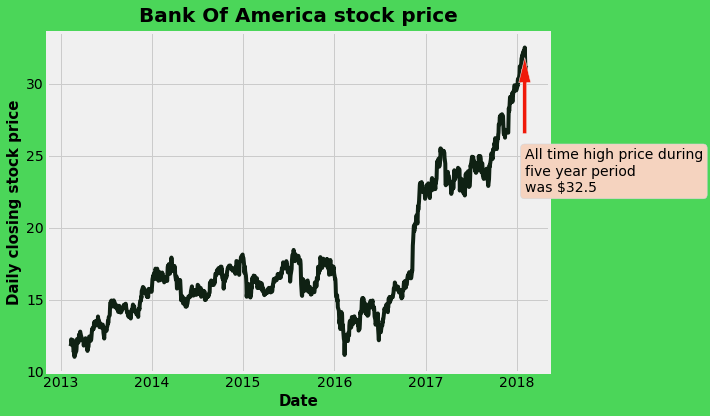

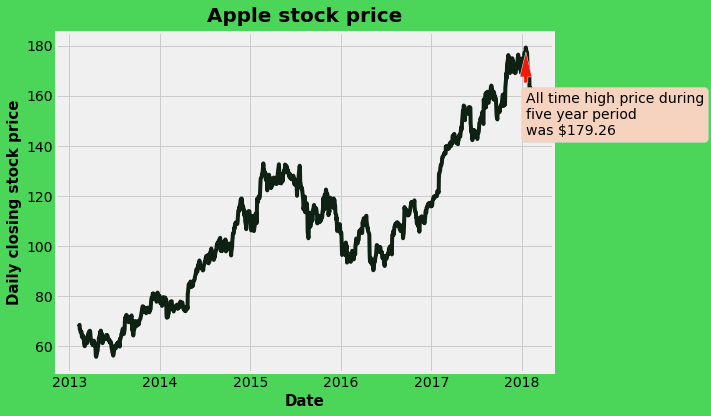

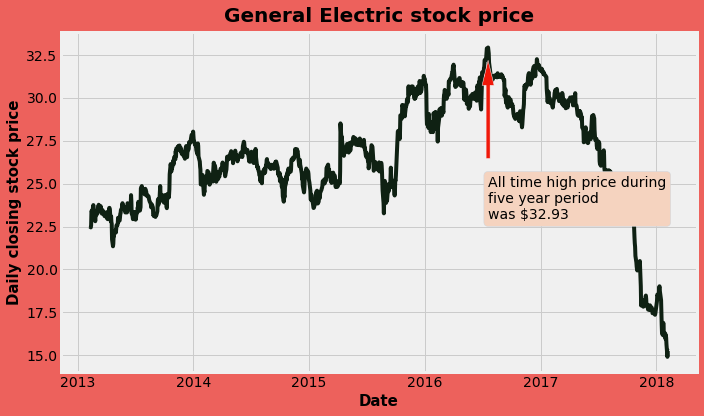

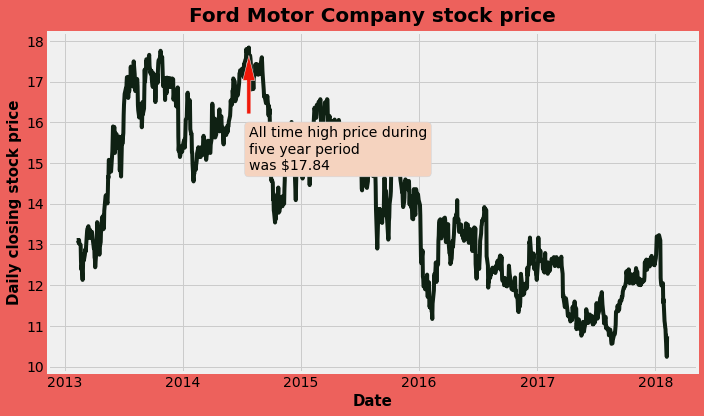

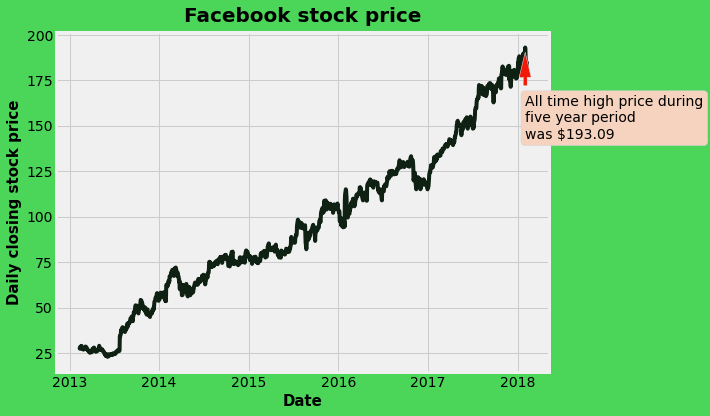

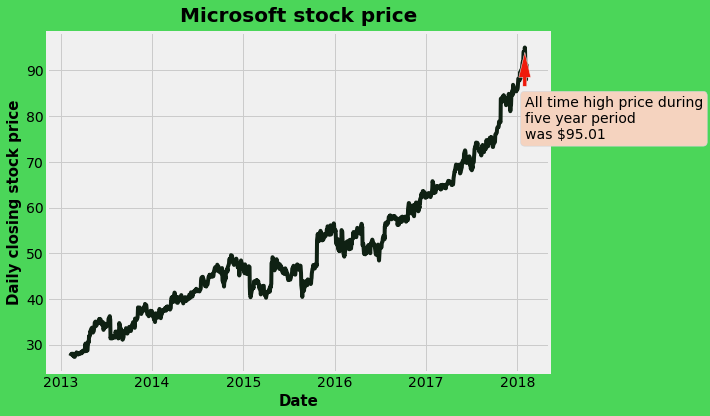

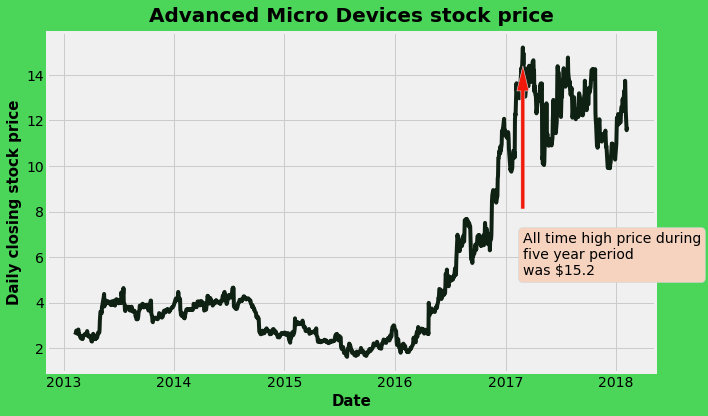

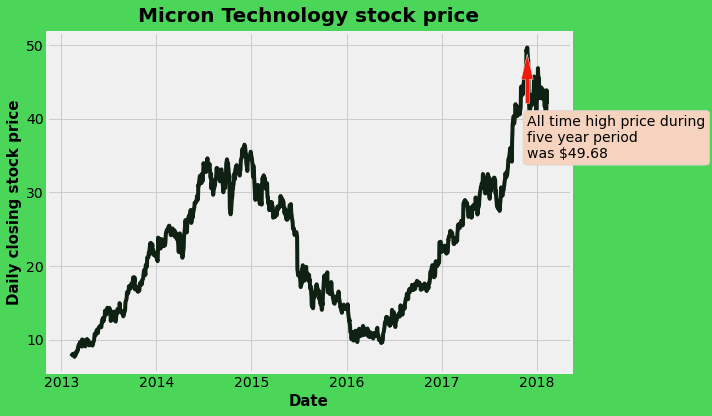

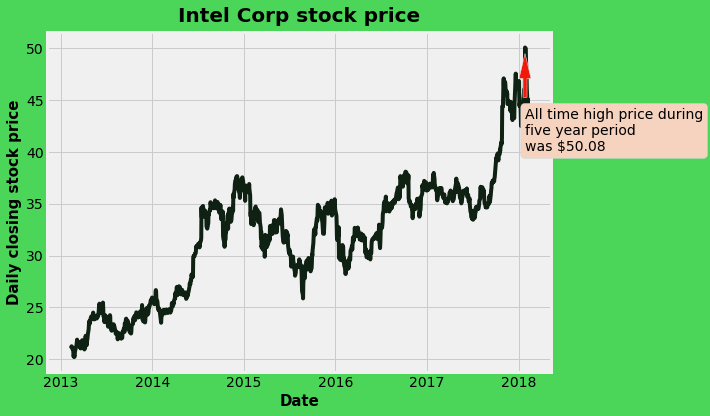

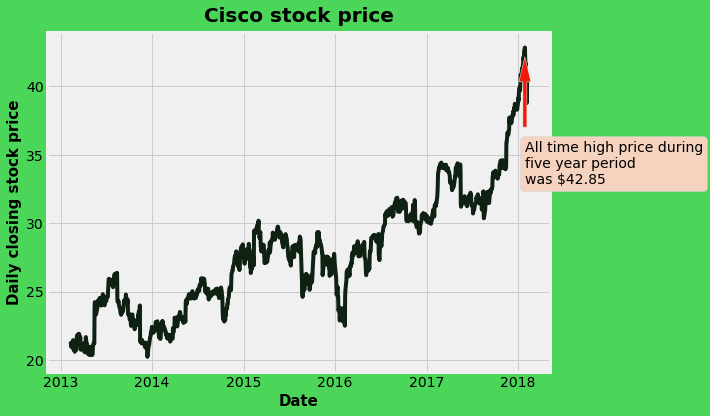

In [10]:
# function return closing stock price over a 5 years of time period
def closing_stock_price(df):
    
    # define highest stock over 5 period of time with date of the same
    high = df['close'].max()
    datetime = df[df['close'] == df['close'].max()]['date'].values
    
    if df['ticks'].unique()[0] == 'GE':
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#ed615c')
    elif df['ticks'].unique()[0] == 'F':
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#ed615c')
    else:
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['date'], df['close'], color='#0f2113')
    ax.set_title(f"{df['co_name'].unique()[0]} stock price", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily closing stock price", fontsize=15)
    if df['ticks'].unique()[0] == 'AAPL':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-35),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'F':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-3),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'FB':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-50),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'MSFT':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-20),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'MU':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-15),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    else:
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-10),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))

    plt.show()
    
# plot of all the closing stocks
closing_stock_price(bac_df)
closing_stock_price(aapl_df)
closing_stock_price(ge_df)
closing_stock_price(f_df)
closing_stock_price(fb_df)
closing_stock_price(msft_df)
closing_stock_price(amd_df)
closing_stock_price(mu_df)
closing_stock_price(intc_df)
closing_stock_price(csco_df)

KEY FINDINGS: 
-We could find TOP 10 most traded stocks during period of 2013-2018.
-Out of 10 companies one is a bank, 7 of them are tech companies, another 2 are non-tech legacy companies namely General  Electric and Ford Motors. 
-From closing stock price visualization, we can learn that stocks 'GE' and 'F' are declining and other tech stocks are rising over a five year period of time. 
-As we can see visualizations are self-explanatory and we can learn all time high stock prices of all the tickers. 

LIFECYCLE OF COMPANIES AND PRODUCTS: 
    
-We can observe from above plots that stock prices of companies like FORD and GE are declining while tech companies' stocks are rising rapidly. This indicates the course or lifecycle of companies. 
-In the image below one can observe the lifecycle of any company or product from startup phase to decline stage. This is the most general theory in business that typical companies follow such cycles.

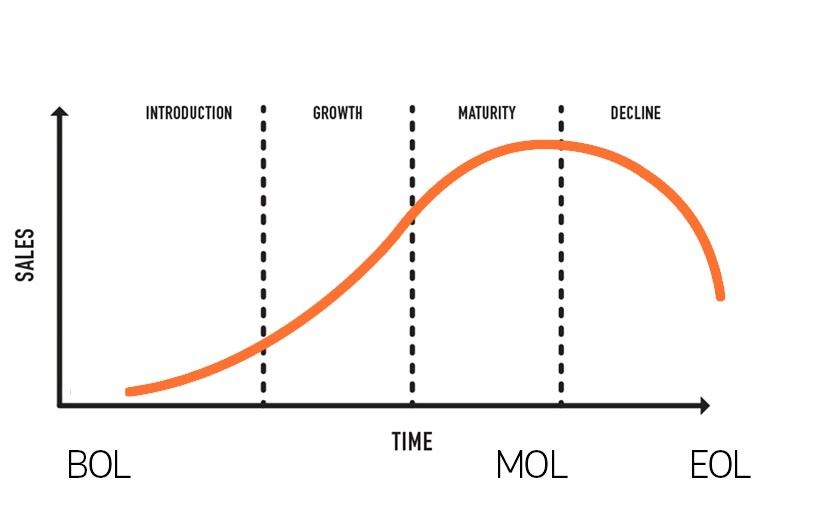

                    TRADE VOLUME OF STOCKS OVER A PERIOD OF 2013-2018

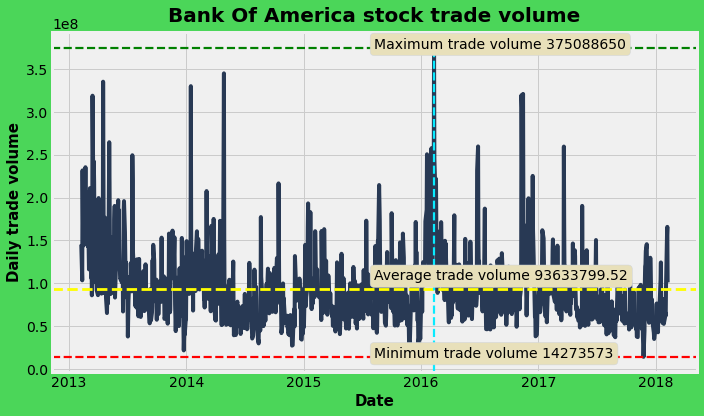

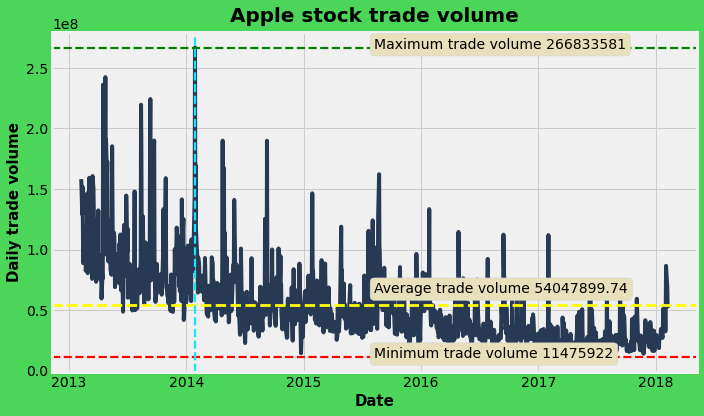

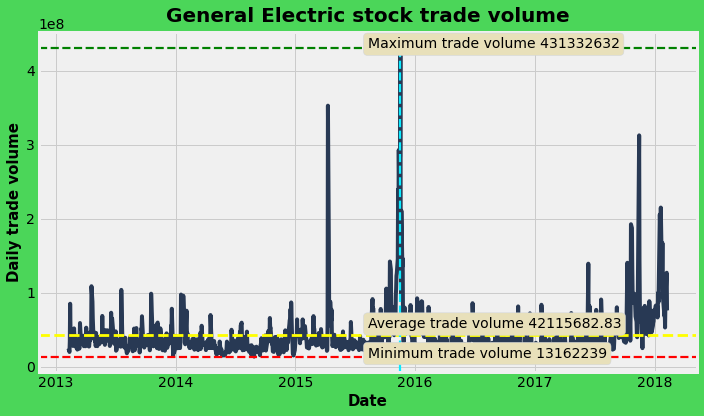

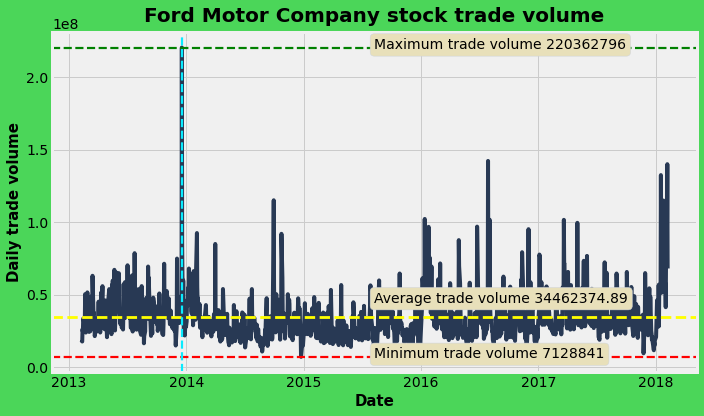

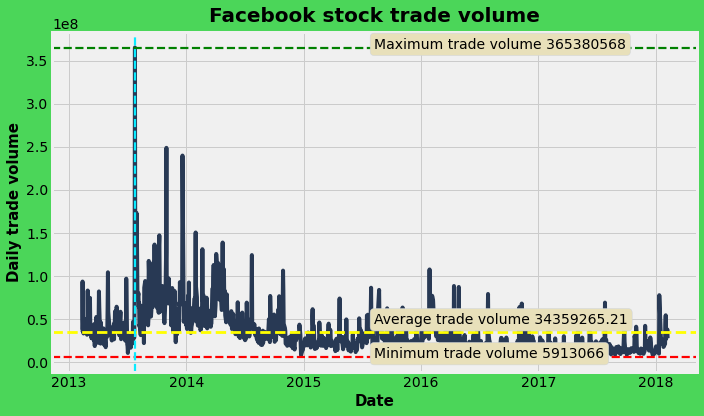

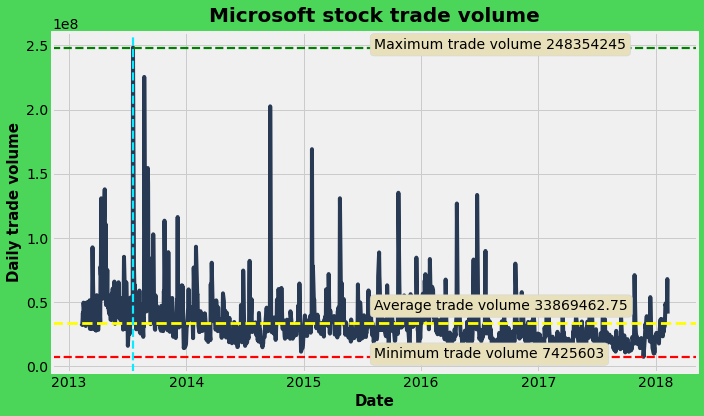

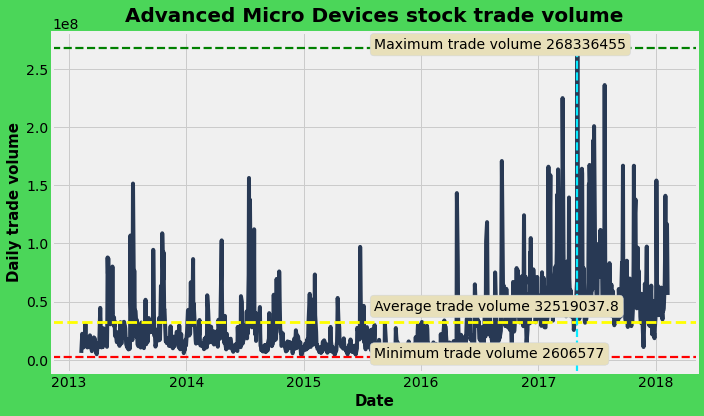

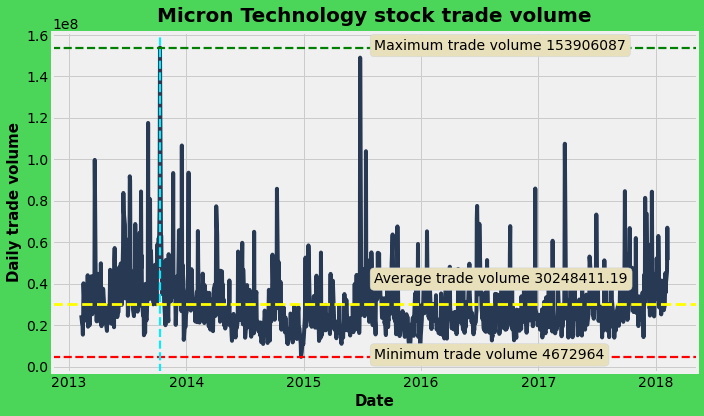

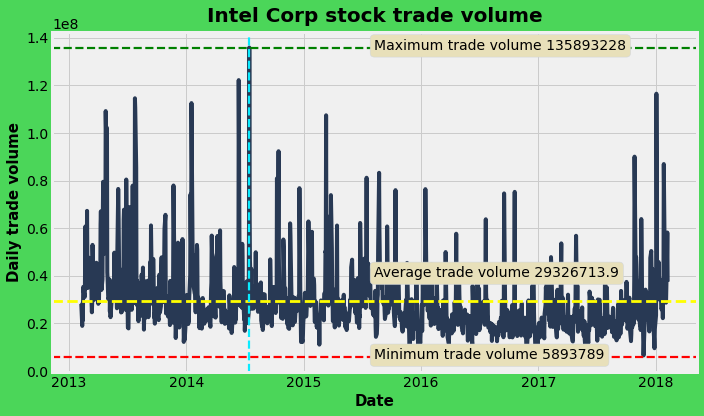

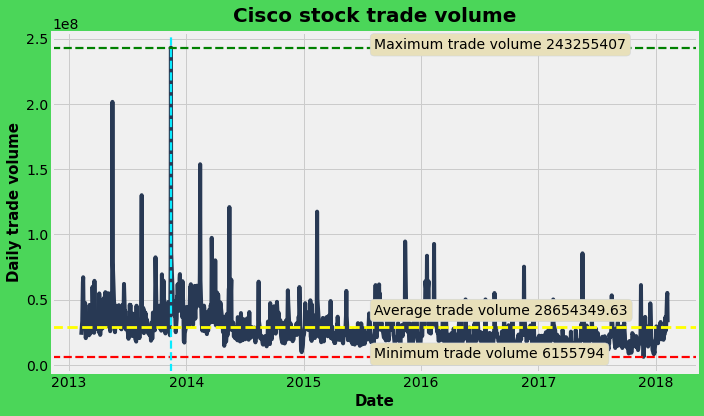

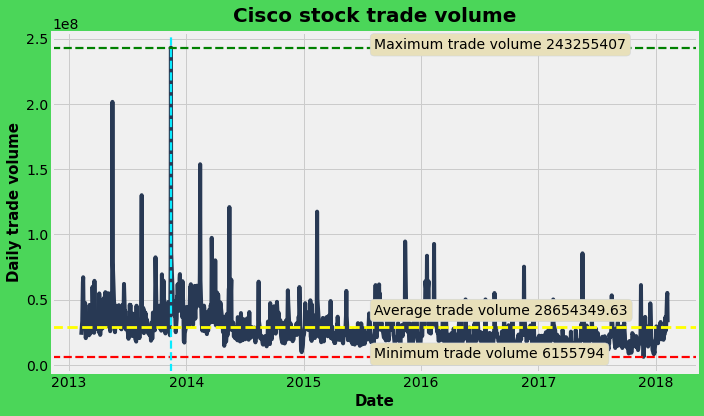

In [11]:
# function to visualize trade volume of stocks
def trade_vol(df):
    
    # x and y coords for average trade volume
    ave_x = df['date'].mean()
    ave_y = df['volume'].mean()
    # y coord for max trade vol
    max_y = df['volume'].max()
    # y coord for min trade vol
    min_y = df['volume'].min()
    
    fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['date'], df['volume'], color='#283954')
    ax.set_title(f"{df['co_name'].unique()[0]} stock trade volume", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily trade volume", fontsize=15)
    ax.axhline(y=df['volume'].max(), linestyle='--', lw=2.2, color='green')
    ax.axhline(y=df['volume'].min(), linestyle='--',lw=2.2, color='red')
    ax.axhline(y=df['volume'].mean(), linestyle='--',lw=2.8, color='yellow')
    ax.axvline(x=df[df['volume'] == max_y]['date'].values, ls='--', lw='2.2', color='#0aebff')
    ax.annotate(f"Average trade volume {round(df['volume'].mean(),2)}", 
                xy=(ave_x,ave_y),xytext=(ave_x,ave_y + 10000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Maximum trade volume {df['volume'].max()}", 
                xy=(ave_x,max_y),xytext=(ave_x,max_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Minimum trade volume {df['volume'].min()}", 
                xy=(ave_x,min_y),xytext=(ave_x,min_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    
    plt.show()
    

# plot of all stocks trade volume
trade_vol(bac_df)
trade_vol(aapl_df)
trade_vol(ge_df)
trade_vol(f_df)
trade_vol(fb_df)
trade_vol(msft_df)
trade_vol(amd_df)
trade_vol(mu_df)
trade_vol(intc_df)
trade_vol(csco_df)
trade_vol(csco_df)
    

OBSERVATIONS: 
- Above visualizations dedpicts what was the maximum, minimum and average trade volume over a period of 5 years between 2013 and 2018. 
- As visualizations are self-explanatory in nature we can also learn variance of trade volume for example stock ticker 'INTC' has highest variance in trade volume compared to other tickers. 

                        COMPARATIVE ANALYSIS OF 7 TECH STOCKS

What is comparative analysis of stocks in finance and investment industry?
- An important aspect of the fundamental analysis of stocks is comparing stocks of the same sector. The most basic way to analyse and compare stocks from the same sector is to conduct an analysis of different ratios like Earnings per share (EPS), Price-to-Earnings (P/E Ratio), Return on Equity (ROE), Return on Capital Employed (ROCE), and Debt-to-Equity ratios, and stock-prices of various companies, trade volume of stocks.
- In this project, due to limited data of companies, we can only compare daily mean stock price of companies and can make inferences like stock price comparison and relative stock price fluctuations. 

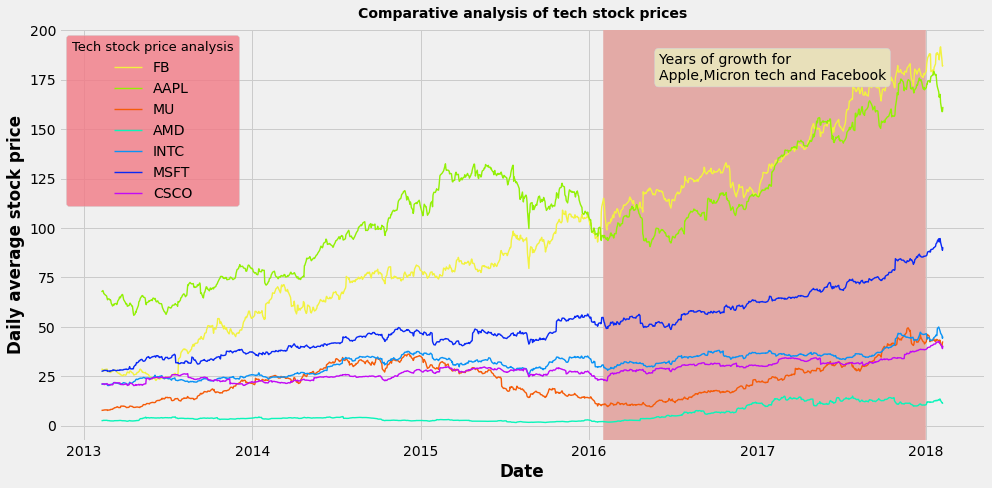

In [12]:
fig, ax = plt.subplots(figsize = (14,7))
ax.plot(fb_df['date'], fb_df['daily_mean'], label = 'FB', color = '#f2f23f', lw = 1.4)
ax.plot(aapl_df['date'], aapl_df['daily_mean'],label='AAPL', color='#92f005', lw=1.4)
ax.plot(mu_df['date'], mu_df['daily_mean'],label='MU', color='#f55c0a', lw=1.4)
ax.plot(amd_df['date'], amd_df['daily_mean'],label='AMD', color='#0af5ba', lw=1.4)
ax.plot(intc_df['date'], intc_df['daily_mean'],label='INTC', color='#0a93f5', lw=1.4)
ax.plot(msft_df['date'], msft_df['daily_mean'],label='MSFT', color='#0a29f5', lw=1.4)
ax.plot(csco_df['date'], csco_df['daily_mean'],label='CSCO', color='#c20af5', lw=1.4)
ax.axvspan(*mdates.datestr2num(['2/1/2016','12/31/2017']), color='#e3aaa6')
ax.set_title("Comparative analysis of tech stock prices")
ax.annotate("Years of growth for\nApple,Micron tech and Facebook", xy=(mdates.datestr2num('6/1/2016'),175),
           bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'))
ax.set_xlabel("Date")
ax.set_ylabel("Daily average stock price")
ax.legend(facecolor='#f27985', fontsize="medium", title="Tech stock price analysis", title_fontsize=13)

plt.show()

Observations: 
- It is very clear that 'FB' stock was one of the most expensive among all 7 tech stocks. 
- stock ticker 'AMD' was among the cheapest to buy compared to other stocks. 
- From above chart we can also conclude that stocks like 'FB' and 'AAPL' were among the most volatile in nature than other stocks.

FIND OUT GROWTH OF STOCKS OF THE COMPANIES OVER A 5 YEAR PERIOD

Growth of stock prices
- In finance and investment industry, stock price growth is really important metric one needs to measure to find out the how is stock or investment of an individual is growing
- Below is the formula to find out growth of stock prices

GROWTH RATE FORMULA = (FINAL VALUE - INITIAL VALUE) / INITIAL VALUE 

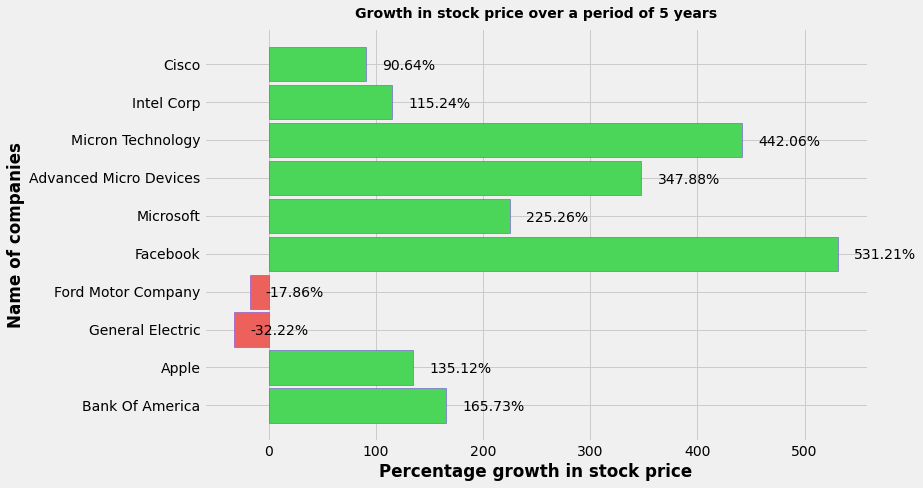

In [13]:
list_df = [bac_df, aapl_df, ge_df, f_df, fb_df, msft_df, amd_df, mu_df, intc_df, csco_df]

mini = [df[df['date'] == df['date'].min()]['close'].values.item() for df in list_df]
maxi = [df[df['date'] == df['date'].max()]['close'].values.item() for df in list_df]

diff = np.array(maxi) - np.array(mini)

growth = (diff/mini) * 100 
growth_list = growth.tolist()
co_name_list = [df['co_name'].unique()[0] for df in list_df]

fig, ax = plt.subplots(figsize = (13,7))
ax.barh(y = co_name_list, width = growth_list, height = 0.9, color = ['#4bd659', '#4bd659', '#ed615c', '#ed615c','#4bd659','#4bd659', '#4bd659', '#4bd659', '#4bd659', '#4bd659'], 
        edgecolor = '#713ae8')
for p in ax.patches: 
    ax.annotate(f'{round(p.get_width(),2)}%', (p.get_width()+15, p.get_y()+0.3))
ax.set_xlabel('Percentage growth in stock price')
ax.set_ylabel('Name of companies')
ax.set_title("Growth in stock price over a period of 5 years")
plt.show()

Observations

- We can observe that growth of stock 'Facebook' is the highest among all other 10 stocks over a period of 5 years
- It is very much self-explanotary that stocks of 'Ford Motors' and 'General Electric' has given negative return over a years of period.

Daily return of stock prices analysis

Daily return hypothesis test
- In stock market, you will often hear that daily return of any stock price is 0% which means you will get zero return on your investment in one day.
- So let's prove the hypothesis by analysing top 10 most traded stocks and assesing their daily return distribution in this section

- H0: Daily return is zero

- Ha: Daily return is not zero

We will prove this hypothesis as a one sample t-test as we know population mean but are not aware of std deviation. if p-value is greater than 0.05 than we can not reject the null hypothesis and if it is less than 0.05 than we have to reject the null hypothesis.

In [14]:
result_dict = {}
for df in list_df: 
    result = stats.ttest_1samp(df['daily return'], 0)
    result_dict[df['ticks'].unique()[0]] = result
result_dict

{'BAC': Ttest_1sampResult(statistic=-0.3532776176429947, pvalue=0.7239395130534507),
 'AAPL': Ttest_1sampResult(statistic=0.41429430560560754, pvalue=0.6787292124343915),
 'GE': Ttest_1sampResult(statistic=-0.6899014787481069, pvalue=0.490383391591772),
 'F': Ttest_1sampResult(statistic=-1.829967497402379, pvalue=0.06749132535767648),
 'FB': Ttest_1sampResult(statistic=0.4317992311745167, pvalue=0.665961331814306),
 'MSFT': Ttest_1sampResult(statistic=2.936864998172622, pvalue=0.00337582087561039),
 'AMD': Ttest_1sampResult(statistic=0.5320769266138294, pvalue=0.5947666691710993),
 'MU': Ttest_1sampResult(statistic=-0.39122335657215007, pvalue=0.6956983959552627),
 'INTC': Ttest_1sampResult(statistic=3.0472693720373076, pvalue=0.002357434011831407),
 'CSCO': Ttest_1sampResult(statistic=2.689287118677755, pvalue=0.007255138945761937)}

- From the above results, we can learn that pvalues of stocks "MSFT", "INTC" and "CSCO" are less than 0.05 so we can reject the null hypothesis and accept alternative hypothesis that is 'Daily return is not zero' while for other stocks we cannot reject null hypothesis. 
- Statistically it proves that 7 out of 10 have a daily return of zero percentage which is the most general case. 

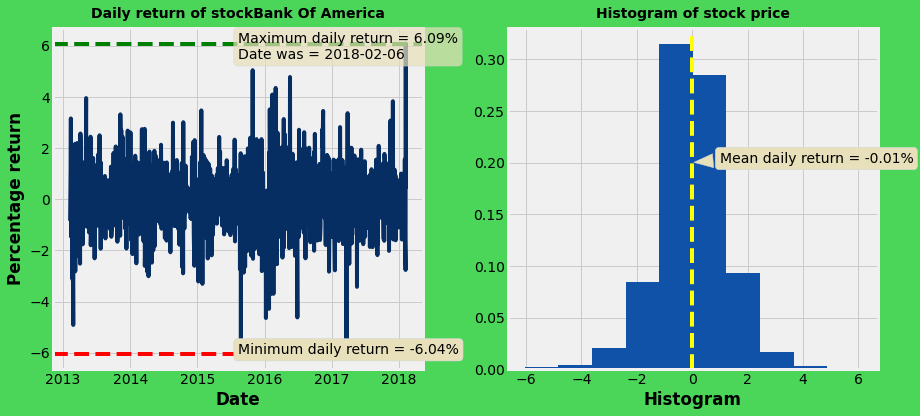

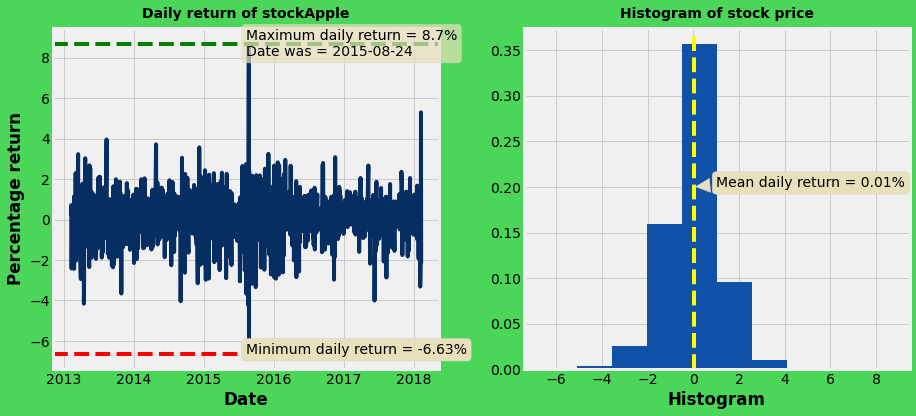

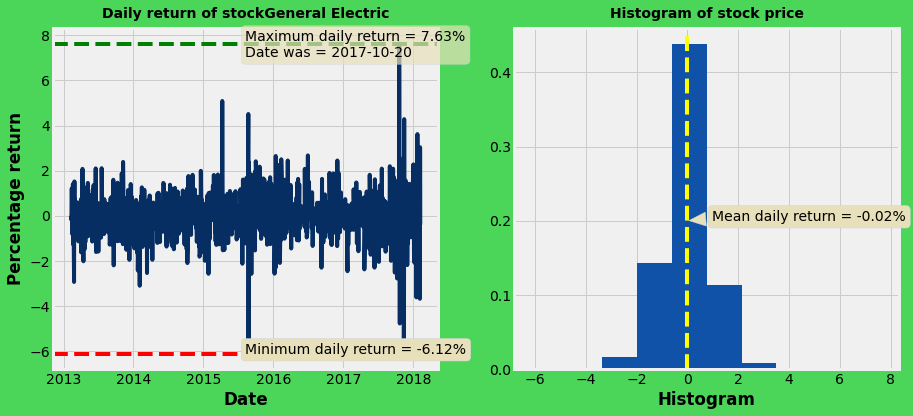

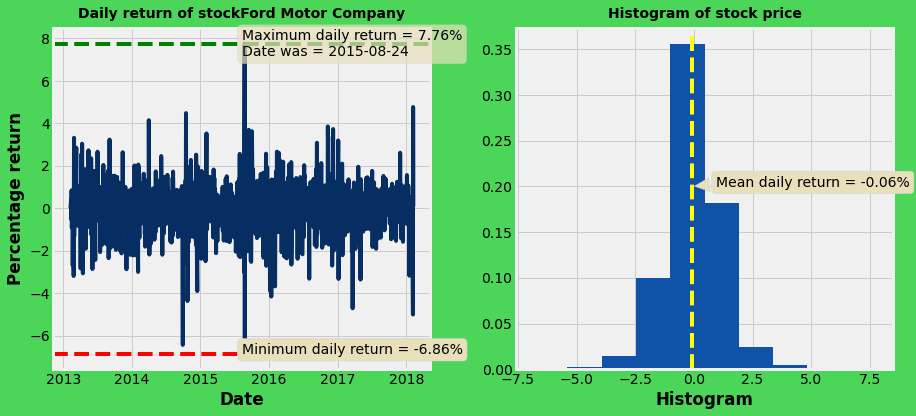

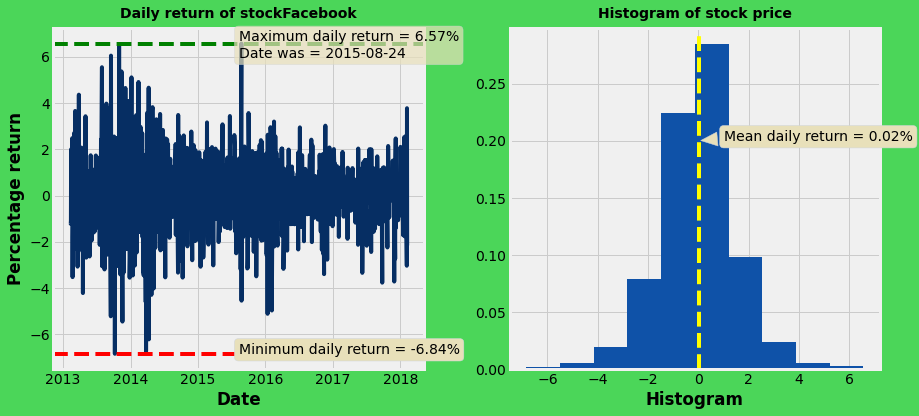

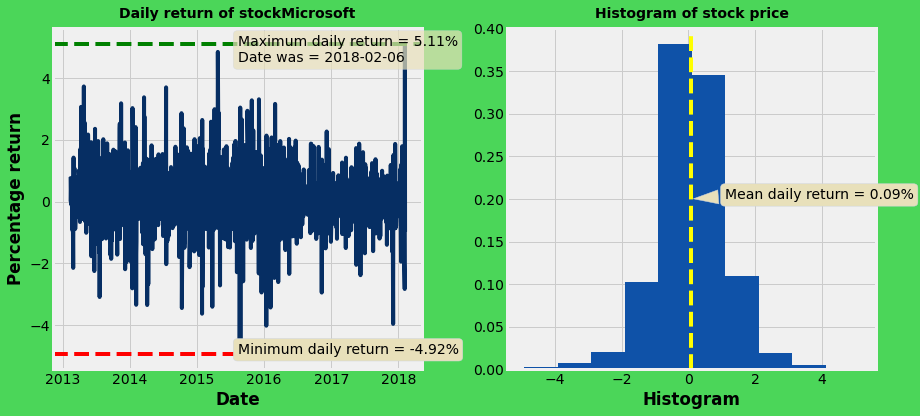

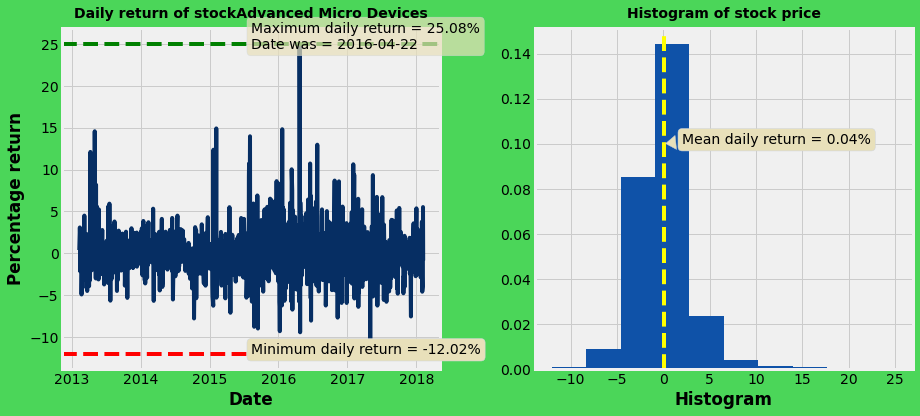

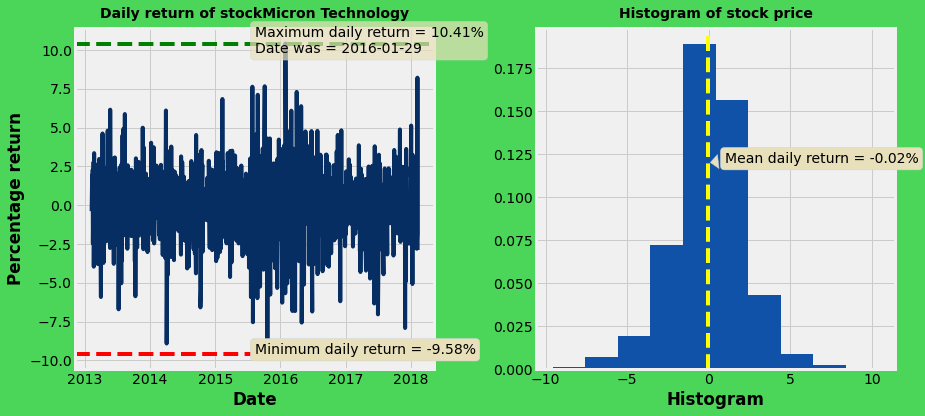

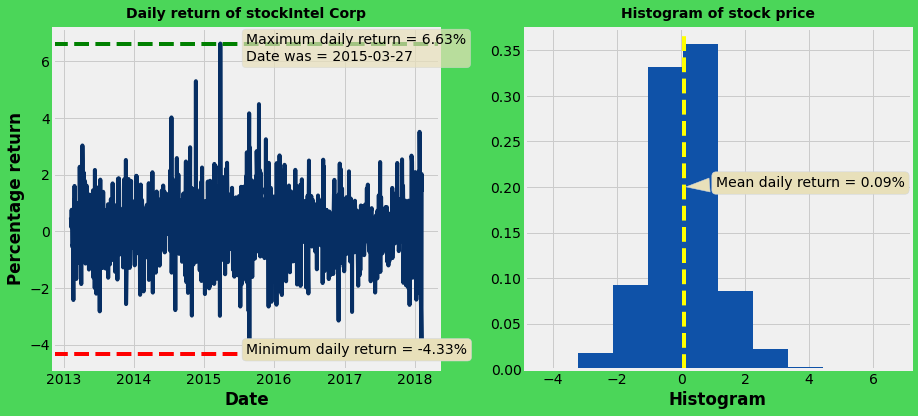

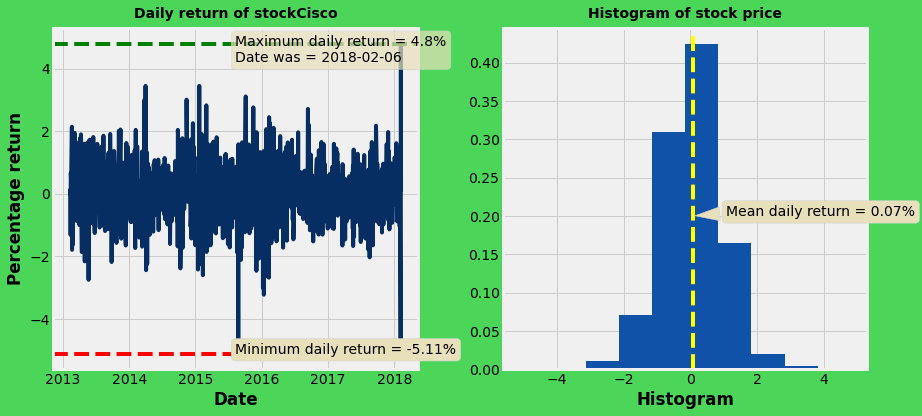

In [15]:
def daily_return(df): 
    
    ave_x = df['date'].mean()
    y_max = df['daily return'].max()
    y_max_date = df[df['daily return'] == df['daily return'].max()]['date'].values
    dt = pd.to_datetime(y_max_date, '%Y%m%d%H%M%S')
    xb = dt.item().date()
    y_min = df['daily return'].min()
    y_mean = df['daily return'].mean()
    
    plt.figure(figsize = (13,6), facecolor = '#4bd659')
    
    plt.subplot(121)
    plt.plot(df['date'], df['daily return'], color = '#062e63')
    plt.axhline(y = df['daily return'].max(), color = 'green', ls = '--')
    plt.axhline(y = df['daily return'].min(), color = 'red', ls = '--')
    plt.xlabel('Date')
    plt.ylabel('Percentage return')
    plt.annotate(f"Minimum daily return = {round(df['daily return'].min(), 2)}%", 
                 xy = (ave_x, y_min), xytext = (ave_x, y_min), 
                 bbox = dict(boxstyle = "round", facecolor = '#e8e0ba', edgecolor = '#d0d5db'))
    plt.annotate(f"Maximum daily return = {round(df['daily return'].max(), 2)}%\nDate was = {xb}", 
                 xy = (ave_x, y_max), xytext = (ave_x, y_max-0.6), 
                 bbox = dict(boxstyle = "round", facecolor = '#e8e0ba', edgecolor = '#d0d5db', alpha = 0.7))
    plt.title(f"Daily return of stock{df['co_name'].unique()[0]}")
    
    plt.subplot(122)
    plt.hist(df['daily return'], density = True, color = '#0f52a8')
    plt.xlabel('Histogram')
    plt.axvline(x = df['daily return'].mean(), color = 'yellow', ls = '--')
    if df['ticks'].unique()[0] == 'AMD': 
        plt.annotate(f"Mean daily return = {round(df['daily return'].mean(), 2)}%", 
                     xy = (y_mean, 0.10), xytext = (y_mean+2, 0.10), 
                     bbox = dict(boxstyle = "round", facecolor = '#e8e0ba', edgecolor = '#d0d5db'), 
                     arrowprops = dict(arrowstyle = "wedge, tail_width = 1.", facecolor = '#e8e0ba', edgecolor = '#d0d5db', 
                                       relpos = (0.1, 0.5)))
    elif df['ticks'].unique()[0] == 'MU':
        plt.annotate(f"Mean daily return = {round(df['daily return'].mean(), 2)}%", 
                     xy = (y_mean, 0.12), xytext = (y_mean+1, 0.12), 
                     bbox = dict(boxstyle = "round", facecolor = '#e8e0ba', edgecolor = '#d0d5db'), 
                     arrowprops = dict(arrowstyle = "wedge, tail_width = 1.", facecolor = '#e8e0ba', edgecolor = '#d0d5db', 
                                       relpos = (0.1, 0.5)))
        
    else: 
        plt.annotate(f"Mean daily return = {round(df['daily return'].mean(), 2)}%", 
                     xy = (y_mean, 0.20), xytext = (y_mean+1, 0.20), 
                     bbox = dict(boxstyle = "round", facecolor = '#e8e0ba', edgecolor = '#d0d5db'), 
                     arrowprops = dict(arrowstyle = "wedge, tail_width = 1.", facecolor = '#e8e0ba', edgecolor = '#d0d5db', 
                                       relpos = (0.1, 0.5)))
        
    plt.title(f"Histogram of stock price")
    
    plt.show()
    
daily_return(bac_df)
daily_return(aapl_df)
daily_return(ge_df)
daily_return(f_df)
daily_return(fb_df)
daily_return(msft_df)
daily_return(amd_df)
daily_return(mu_df)
daily_return(intc_df)
daily_return(csco_df)

            TECHNICAL ANALYSIS OF STOCKS USING CANDLE STICK CHARTS AND MOVING AVERAGE 

An open-high-low-close chart (also OHLC) is a type of chart typically used to illustrate movements in the price of a financial instrument over time. Each vertical line on the chart shows the price range (the highest and lowest prices) over one unit of time, e.g., one day or one hour. Tick marks project from each side of the line indicating the opening price (e.g., for a daily bar chart this would be the starting price for that day) on the left, and the closing price for that time period on the right. The bars may be shown in different hues depending on whether prices rose or fell in that period.

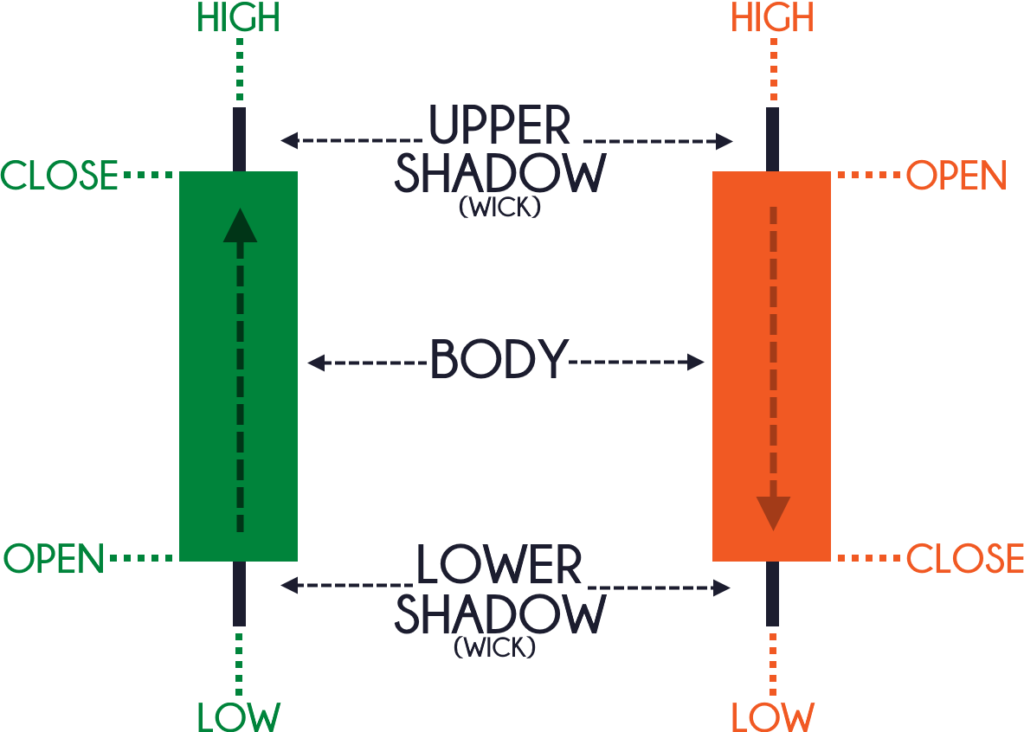

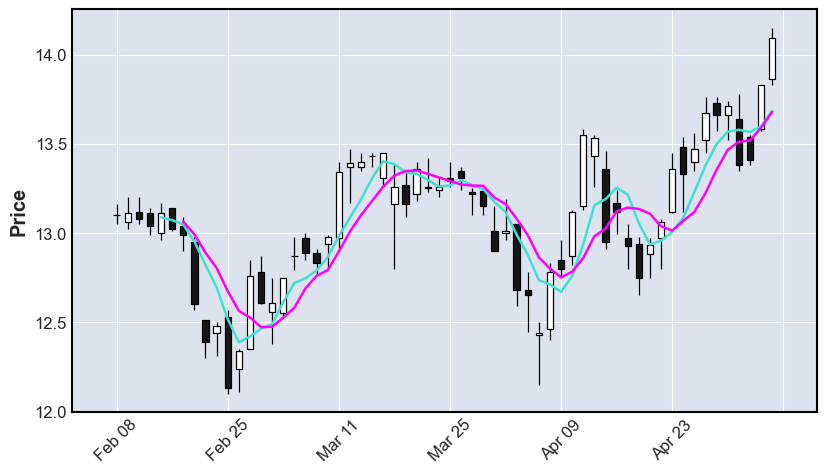

In [16]:
F_df = f_df.copy()
F_df.set_index('date', inplace = True)
F_df
mpf.plot(F_df.iloc[:60,:], type = 'candle', mav = (5,7), figratio = (9,5))

In [17]:
def candlestick_chart(df): 
    trace = go.Candlestick(x = df['date'], 
                           open = df['open'], 
                           high = df['high'], 
                           low = df['low'], 
                           close = df['close'])
    layout = {
        'title' : f"{df['co_name'].unique()[0]}Historical Stock Price", 
        'xaxis' : {'title' : 'Date'}, 
        'yaxis' : {'title' : 'Stock Price (USD$)'}
    }
    
    data = [trace]
    
    fig = go.Figure(data = data, layout = layout)
    fig.update_layout(xaxis_rangeslider_visible = False, paper_bgcolor = '#4bd659')
    fig.show()
    
candlestick_chart(bac_df)
candlestick_chart(aapl_df)
candlestick_chart(ge_df)
candlestick_chart(f_df)
candlestick_chart(fb_df)
candlestick_chart(msft_df)
candlestick_chart(amd_df)
candlestick_chart(mu_df)
candlestick_chart(intc_df)
candlestick_chart(csco_df)

                            MOVING AVERAGE CHARTS OF FACEBOOK AND APPLE 

Moving average of stocks
A moving average (MA) is a stock indicator commonly used in technical analysis, used to help smooth out price data by creating a constantly updated average price. A rising moving average indicates that the security is in an uptrend, while a declining moving average indicates a downtrend.


Moving average is one of the most widly used stock market forecasting method in finance industry, in this section we will plot and analyse stocks of 'FACEBOOK' and 'APPLE' using 10, 50 and 200 days moving averages to find uptrend and downtrends

In [18]:
def mav_function(df): 
    
    df['10_d_avg'] = df['close'].rolling(window=10).mean()
    df['50_d_avg'] = df['close'].rolling(window=50).mean()
    df['200_d_avg'] = df['close'].rolling(window=200).mean()
    
    return df

aapl_df = mav_function(aapl_df)
fb_df = mav_function(fb_df)

In [19]:
aapl_dfn = aapl_df.copy()
fb_dfn = fb_df.copy()

def mav_chart(df): 
    df = df.set_index('date')
    
    fig = tls.make_subplots(rows = 2, cols = 1, shared_xaxes = True)
    
    colors = ['#ff4500', '#92a1cf', '#6E6E6E']
    avgs = ['10_d_avg', '50_d_avg', '200_d_avg']
    
    for col, c in zip(avgs, colors): 
        fig.append_trace({'x' : df.index, 'y' : df[col], 'type' : 'scatter', 'name' : col, 'line' : {'color' : c}}, 1, 1)
    for col in ['close']: 
        fig.append_trace({'x' : df.index, 'y' : df[col], 'type' : 'scatter', 'name' : 'closing price', 'line' : {'color' : '#393f5e'}}, 2, 1)
        
    fig['layout'].update(height = 800, title = f"Relationship between Moving averages <br> and Closing Price of {df['co_name'].unique()[0]}", 
                        paper_bgcolor = '#4bd659', plot_bgcolor = '#F2DFCE')
    
    fig.show()

Moving average chart of 'FB'

In [20]:
mav_chart(fb_dfn)

Analysis and Interpretation:

- From above stock chart of 'FB' we can observe that 14th Novemeber, 2016 is the first when 10 Days Moving avearge is going down than 50 Days Moving average which shows declining trends
- On 4th January, 2017 10 Days Moving average starts moving above 200 Days Moving average which shows Upwards trend in 'FB' stock
- Over a period of 5 years FB showed upward trend except only one time which was around Dec. 2016, and reason of that decline was FB got into trouble by reports of 'Cambridge analytica Data scandle', thus stock declined in Dec. 2016

Moving average chart of 'AAPL'

In [21]:
mav_chart(aapl_dfn)

Analysis and Interpretation:

- Apple's stock price shows more irregular fluctuations compared to FB with one major decline during period of 2015-16.
- Around 7th august 2015 10 Days Moving average of Apple's stock price goes below 200 Days Moving average which shows downward trend in apple's stock price.
- And exactly, year after 15th august 2016, 10 Days Moving average crosses 200 Days Moving avearge which show uptrend thereafter.
- By comparing stocks 'FB' and 'AAPL', we can conclude that 'FB' performed better than 'AAPL'. 'FB' showed more consistant growth as well as less fluctions than 'AAPL' which proves the performance of 'FB' stocks. My recommendation is to BUY 'FB' as it has great growth prospects.

                        STOCK PRICE FORECASTING : MODELLING AND FORECAST

Forecasting Using Prophet

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [22]:
def df_formatting(df): 
    df = df.loc[:, ['date', 'close']]
    df.rename(columns = {'date' : 'ds', 'close' : 'y'}, inplace = True)
    
    return df 

aplph_df = df_formatting(aapl_df)
fbph_df = df_formatting(fb_df)

In [23]:
def price_forecasting(df, period): 
    
    prophet = Prophet(yearly_seasonality = 'auto')
    prophet.fit(df)
    future_price = prophet.make_future_dataframe(periods = period)
    forecasts = prophet.predict(future_price)
    forecast = forecasts[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    
    fig = prophet.plot(forecasts)
    a = add_changepoints_to_plot(fig.gca(), prophet, forecasts)
    
    fig2 = prophet.plot_components(forecasts)
    
    return forecasts

'AAPL' stock price forecasting 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


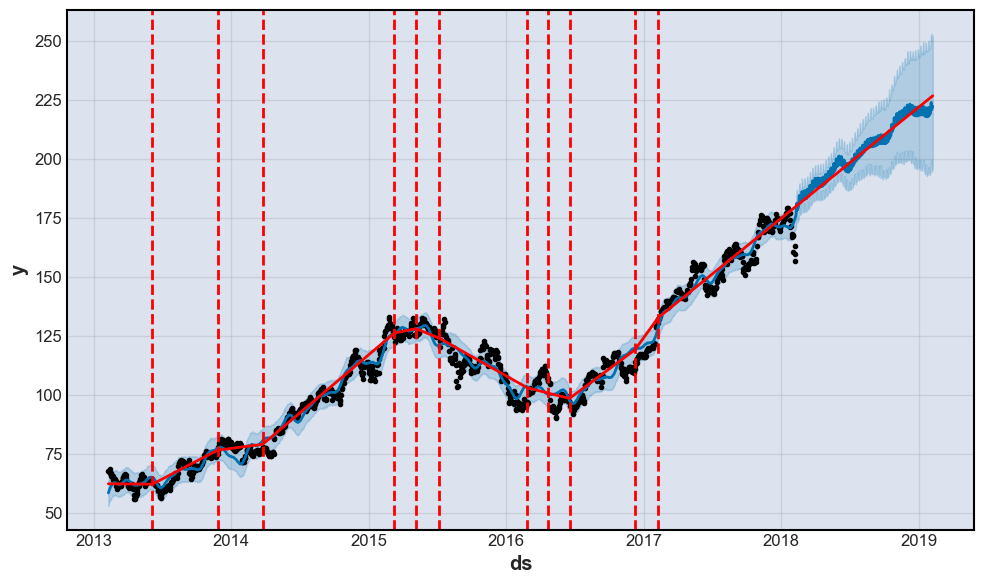

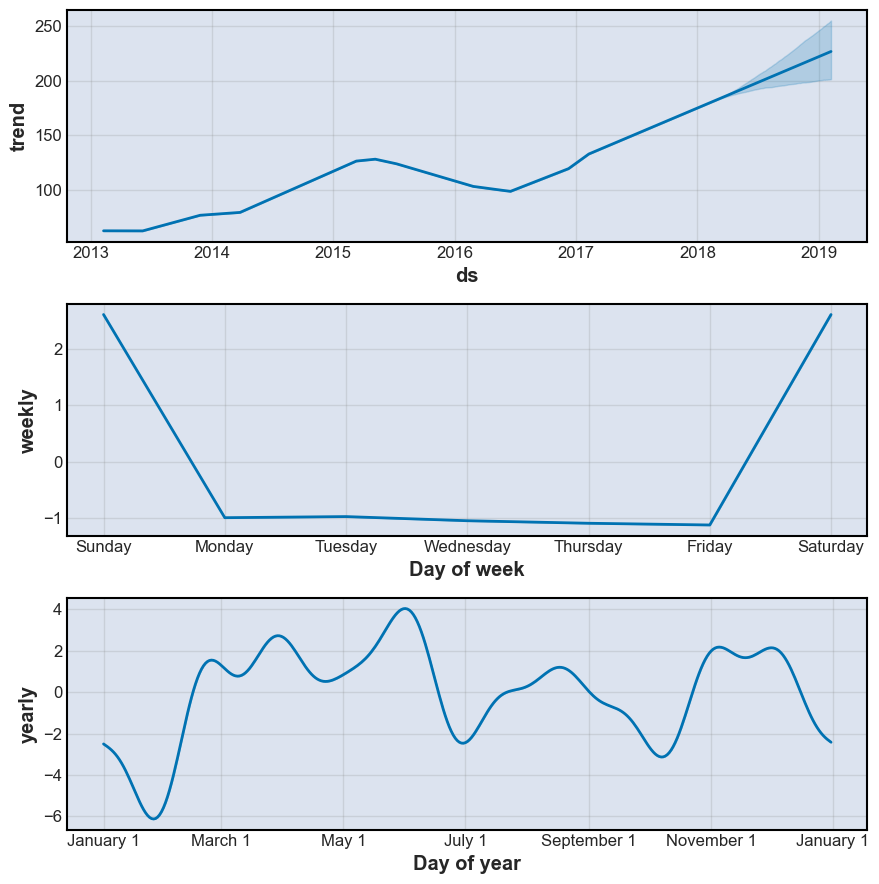

In [24]:
forecast_aapl = price_forecasting(aplph_df, 365)

'FB' stock price forecasting

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


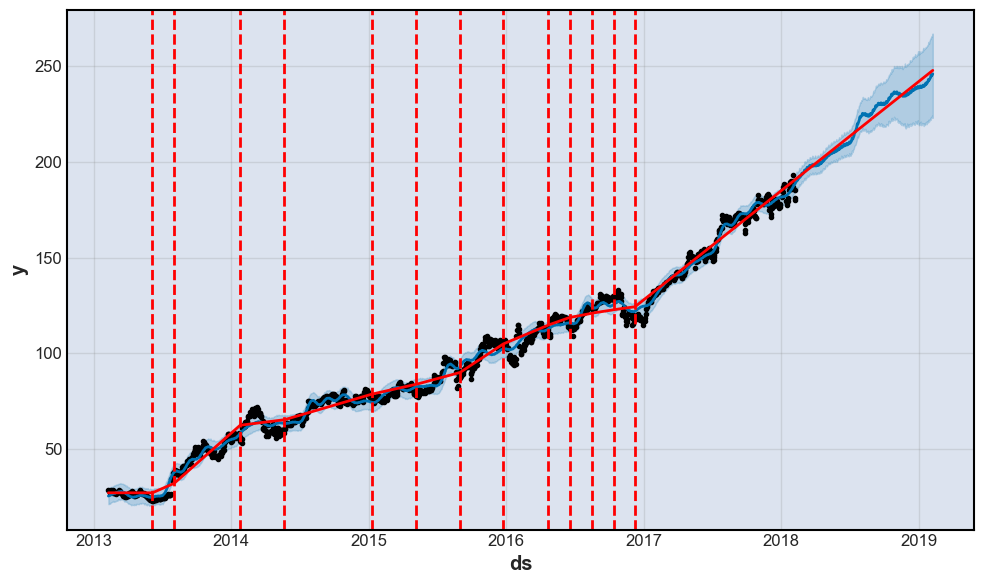

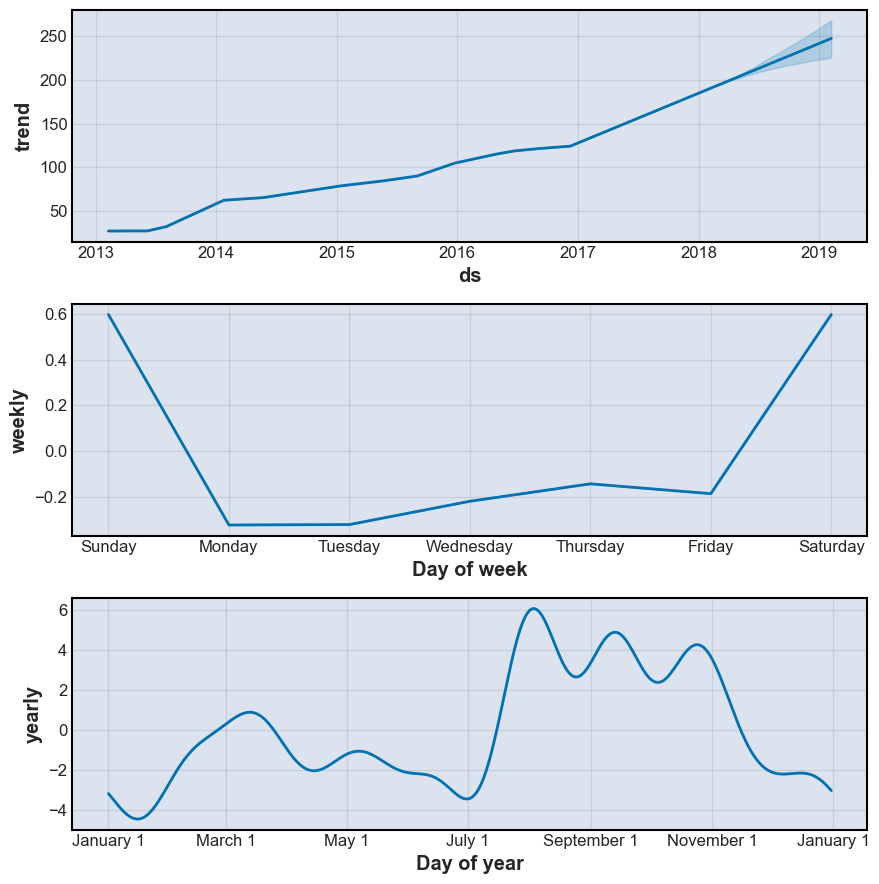

In [25]:
forecast_fb = price_forecasting(fbph_df, 365)

FORECASTING USING AUTO-ARIMA MODELS

1) Seasonal decomposition 2) Autocorrelation 3) adf tests and plots 4) auto differencing 5) auto-arima models 

TIME-SERIES DECOMPOSITION

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [27]:
# let's find seasonla decomposition of time-series models
def decomposition(df, period):
    # decompistion instance
    result_decom = seasonal_decompose(df['y'], model="additive", 
                                      period=period, extrapolate_trend='freq')
    # plot the componenets 
    fig = result_decom.plot()
    fig.set_size_inches((10, 6))
    # Tight layout to realign things
    fig.tight_layout()
    plt.show()
    
    # capture the compoenets 
    trend = result_decom.trend
    season = result_decom.seasonal
    reside = result_decom.resid
    return trend, season, reside

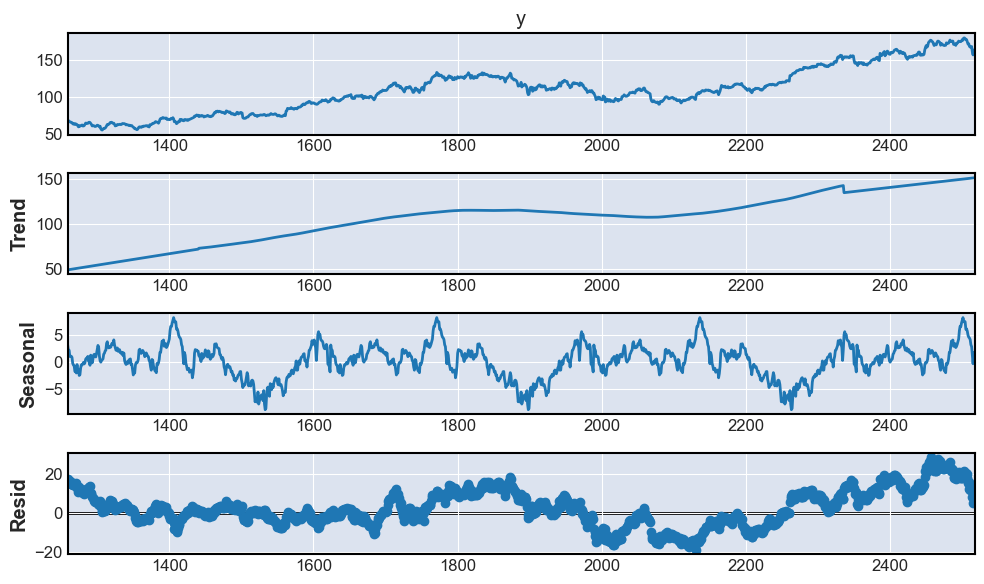

In [28]:
tr, se, re = decomposition(aplph_df, 365)

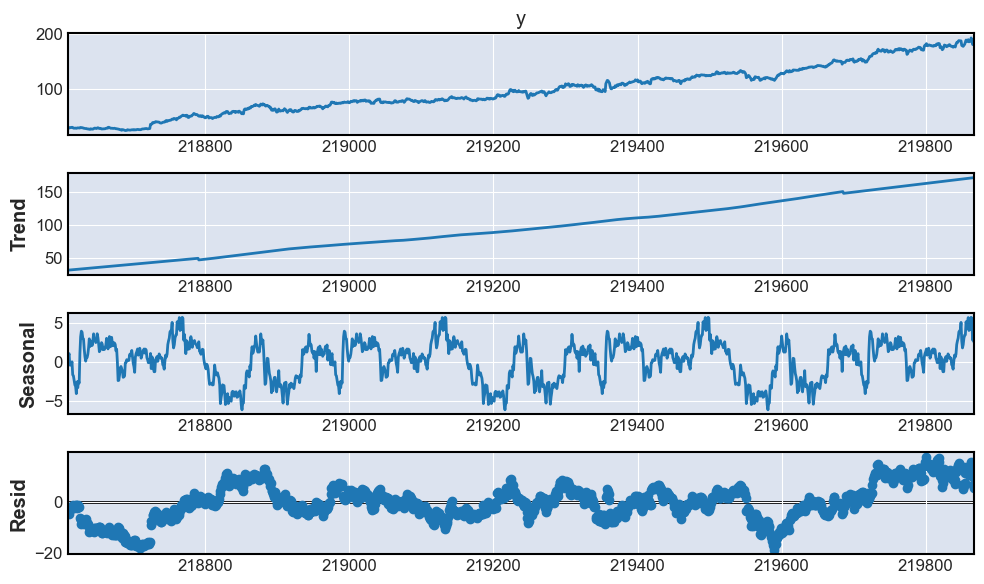

In [29]:
ftr, fse, fre = decomposition(fbph_df, 365)

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [31]:
def acf_pacf(df, lags):
    var = df['y']
   
    fig = plot_acf(var, lags=lags)
    fig.set_size_inches((9, 5))
    fig.tight_layout()
    plt.show()
    
    
    fig = plot_pacf(var, lags=lags)
    fig.set_size_inches((9,5))
    fig.tight_layout()
    plt.show()

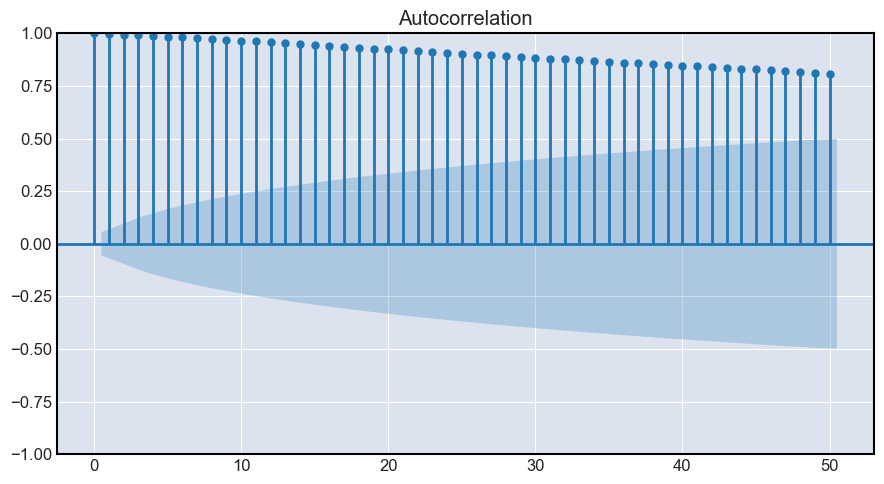

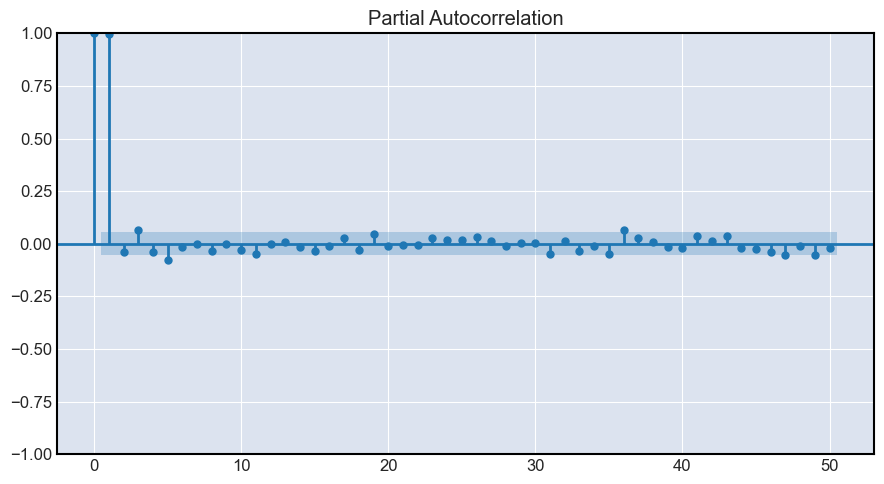

In [32]:
acf_pacf(aplph_df, 50)

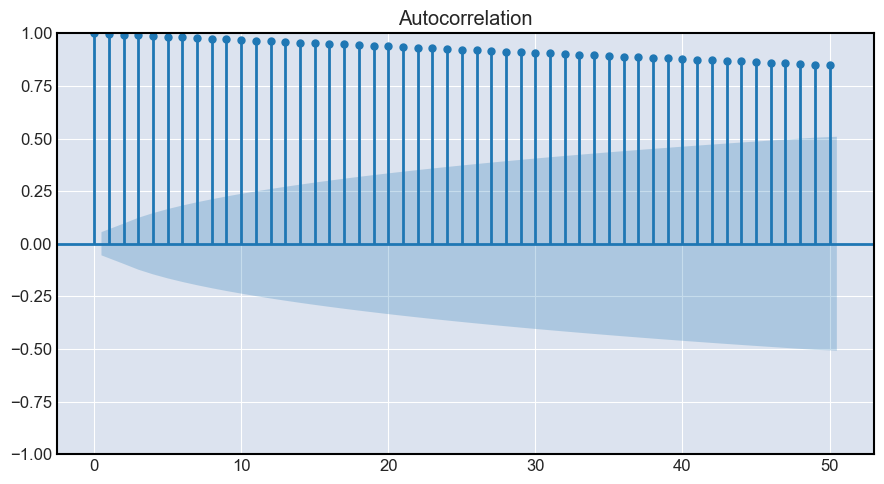

In [33]:
acf_pacf(fbph_df, 50)

Auto-correlation interpretation - Slow decline in auto-correlation indicates time-series not stationary, we can prove the stationarility of time-series by Dicky-fuller test

Partical auto-correlation interpretation - For both stocks PACF suggest that time-series dependence can be captured only 1 lag owing to its significance than other laged time-series

Dicky-Fuller Test(Stationarility test)

- Hypothesis to prove dicky-fuller test: 
    HO - Beta = 1(the time series is non-stationary)
    HA - Beta < 1(the time series is stationary)

In [34]:
from statsmodels.tsa.stattools import adfuller

In [35]:
def adfuller_test(df): 
    adfuller_result = adfuller(df['y'], autolag = 'AIC')
    adfuller_output = pd.Series(adfuller_result[:4], index = ['Test statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    print(adfuller_output)

In [36]:
print("adfuller test results for APPLE")
adfuller_test(aplph_df)
print("----" * 10)
print("adfuller test results for FB")
adfuller_test(fbph_df)
print("----" * 10)

adfuller test results for APPLE
Test statistic                   -0.665091
p-value                           0.855586
Lags Used                         0.000000
Number of Observations Used    1258.000000
dtype: float64
----------------------------------------
adfuller test results for FB
Test statistic                    0.177529
p-value                           0.970973
Lags Used                         8.000000
Number of Observations Used    1250.000000
dtype: float64
----------------------------------------


Both the stocks time-series is not stationary as p-values are much greater than 0.05, hence we cannot reject the null-hypothesis.